In [98]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import time
import math
import scipy.stats as stats
import itertools

In [2]:
# Load AKSI stock dataset
df_aksi = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='AKSI.JK')
df_aksi.set_index('Date', drop=True, inplace=True)
df_aksi.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-04,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-05,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-06,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-07,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0


In [3]:
# Check datatypes
print(df_aksi.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [4]:
# Check missing value
print(df_aksi.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [5]:
# Fill missing value using mean imputation
for i in df_aksi[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_aksi[i].fillna(df_aksi[i].mean(), inplace=True)

print(df_aksi.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


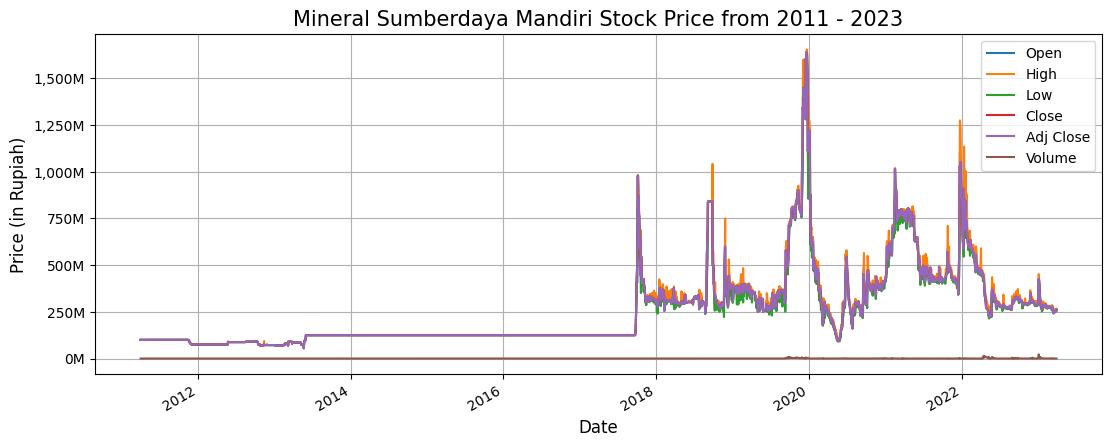

In [6]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_aksi.plot(figsize=(13,5))
plt.title('Mineral Sumberdaya Mandiri Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [7]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_aksi[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [8]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]] 

Testing Scaled:  [[0.43217666]
 [0.40063091]
 [0.49842271]
 [0.4637224 ]
 [0.44164038]]


In [9]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [10]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
start_time=time.time()
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 5s 61ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 2/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 3/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 1s 27ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 7/10
24/24 [==============================] - 1s 27ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 1s 27ms/step - loss: 9.6001e-04 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 1s 27ms/step - loss: 8.6777e-04 - val_loss: 0.0022
Epoch 10/10
24/24 [==============================] - 1s 27ms/step - loss: 8.3280e-04 - val_loss: 0.00

In [11]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 1s 8ms/step
Mean Absolute Error (MAE): 0.0083493
Mean Absolute Percentage Error (MAPE): 0.05302
Root Mean Squared Error (RMSE): 0.01523
Mean Squared Error (MSE): 0.0002319
R-Squared (R2): 0.433078
T-Statistic 0.8779
P-Value 6.769916658516673e-13
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 11ms/step


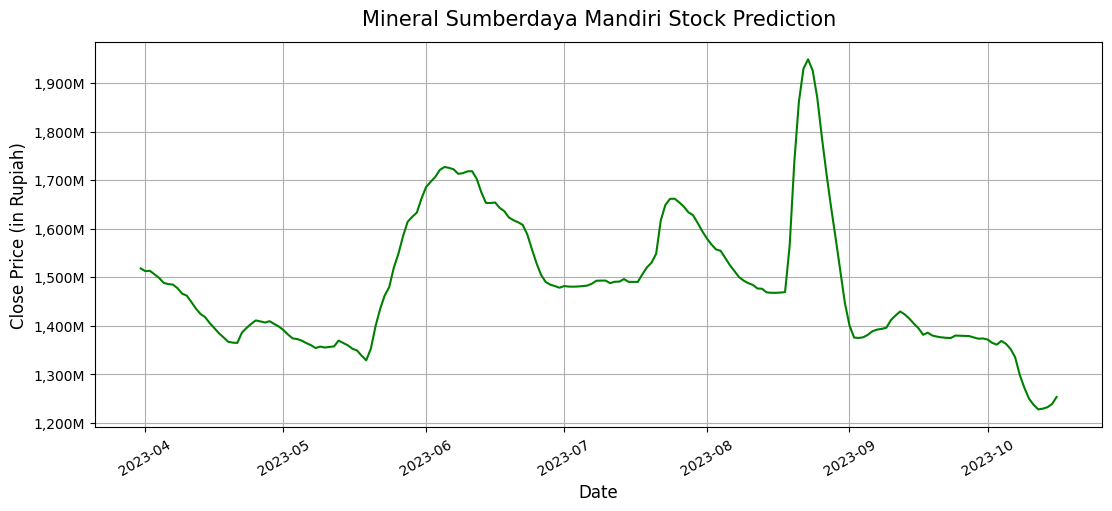

In [12]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [13]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 12s 242ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 2/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 3/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 5/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 6s 264ms/step - loss: 9.4013e-04 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 7s 288ms/step - loss: 8.5895e-04 - val_loss: 0.0024
Epoch 9/10
24/24 [==============================] - 7s 274ms/step - loss: 8.7932e-04 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 7s 297ms/step - loss: 9.2969e-04 -

In [14]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 0.0081616
Mean Absolute Percentage Error (MAPE): 0.05221
Root Mean Squared Error (RMSE): 0.01361
Mean Squared Error (MSE): 0.0001851
R-Squared (R2): 0.547315
T-Statistic 0.8839
P-Value 1.5513730708058282e-12
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 46ms/step


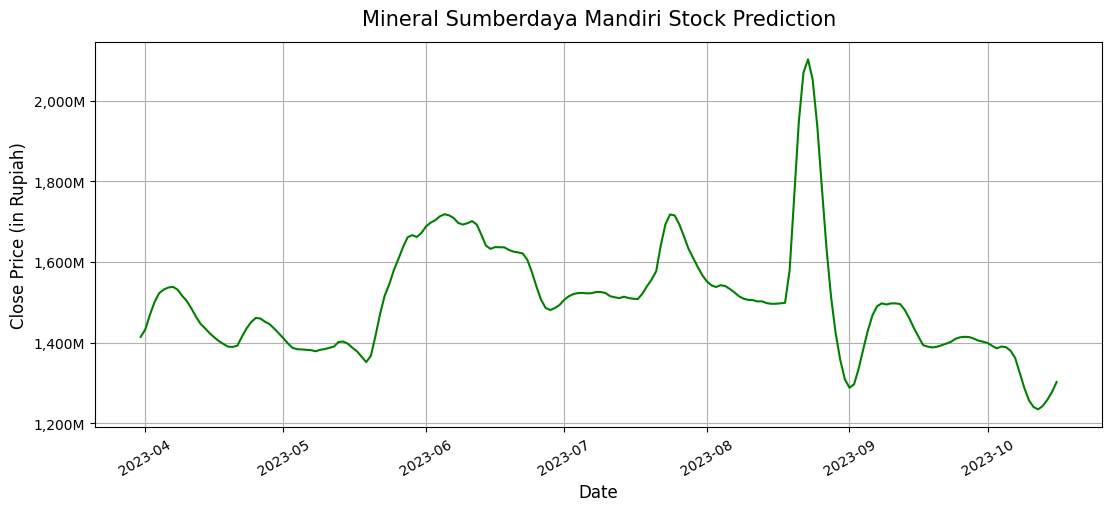

In [15]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [16]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 15s 347ms/step - loss: 0.0201 - val_loss: 0.0841
Epoch 2/10
24/24 [==============================] - 17s 716ms/step - loss: 0.0160 - val_loss: 0.0710
Epoch 3/10
24/24 [==============================] - 18s 741ms/step - loss: 0.0151 - val_loss: 0.0651
Epoch 4/10
24/24 [==============================] - 17s 703ms/step - loss: 0.0143 - val_loss: 0.0628
Epoch 5/10
24/24 [==============================] - 15s 643ms/step - loss: 0.0143 - val_loss: 0.0606
Epoch 6/10
24/24 [==============================] - 18s 764ms/step - loss: 0.0139 - val_loss: 0.0591
Epoch 7/10
24/24 [==============================] - 19s 779ms/step - loss: 0.0138 - val_loss: 0.0578
Epoch 8/10
24/24 [==============================] - 17s 707ms/step - loss: 0.0138 - val_loss: 0.0563
Epoch 9/10
24/24 [==============================] - 18s 751ms/step - loss: 0.0134 - val_loss: 0.0555
Epoch 10/10
24/24 [==============================] - 18s 771ms/step - loss: 0.0128 - val_lo

In [17]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 61ms/step
Mean Absolute Error (MAE): 0.0469115
Mean Absolute Percentage Error (MAPE): 0.3015
Root Mean Squared Error (RMSE): 0.05076
Mean Squared Error (MSE): 0.0025769
R-Squared (R2): -5.300488
T-Statistic 0.829
P-Value 1.7654455727319574e-15
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 58ms/step


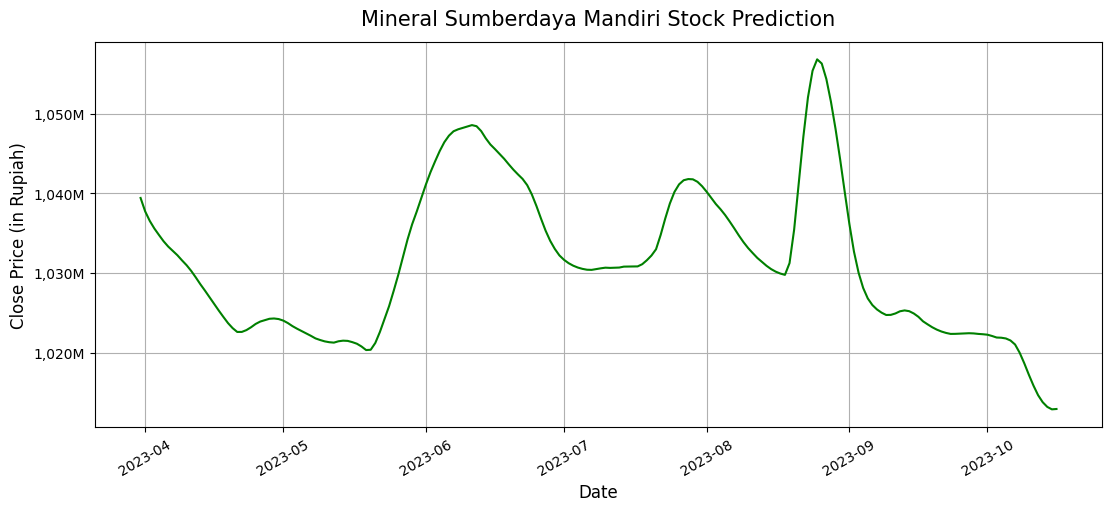

In [18]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [19]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 25s 647ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 2/10
24/24 [==============================] - 12s 507ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 3/10
24/24 [==============================] - 12s 490ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 12s 520ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 12s 509ms/step - loss: 9.8500e-04 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 13s 522ms/step - loss: 9.0981e-04 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 13s 527ms/step - loss: 8.6404e-04 - val_loss: 0.0025
Epoch 8/10
24/24 [==============================] - 14s 571ms/step - loss: 7.9471e-04 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 13s 558ms/step - loss: 8.1948e-04 - val_loss: 0.0022
Epoch 10/10
24/24 [==============================] - 12s 508ms/step - l

In [20]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 54ms/step
Mean Absolute Error (MAE): 0.0136834
Mean Absolute Percentage Error (MAPE): 0.08947
Root Mean Squared Error (RMSE): 0.0179
Mean Squared Error (MSE): 0.0003205
R-Squared (R2): 0.216387
T-Statistic 0.8828
P-Value 1.3372471532879793e-12
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 46ms/step


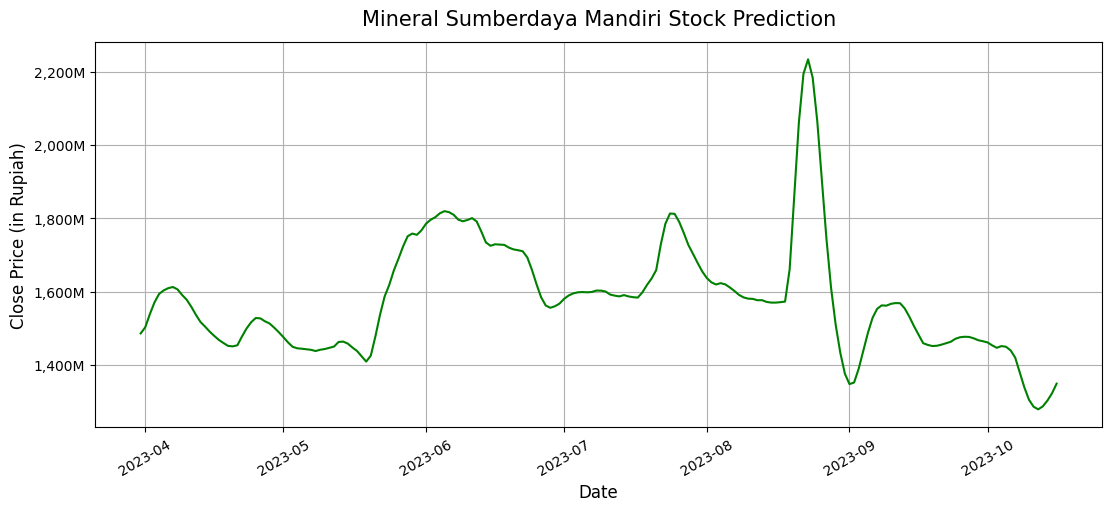

In [21]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [22]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 24s 634ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 2/10
24/24 [==============================] - 14s 581ms/step - loss: 0.0026 - val_loss: 0.0109
Epoch 3/10
24/24 [==============================] - 14s 596ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 4/10
24/24 [==============================] - 14s 597ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 14s 588ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 6/10
24/24 [==============================] - 14s 600ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 13s 558ms/step - loss: 0.0016 - val_loss: 0.0056
Epoch 8/10
24/24 [==============================] - 14s 570ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 12s 513ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 13s 537ms/step - loss: 0.0012 - val_lo

In [23]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.0152281
Mean Absolute Percentage Error (MAPE): 0.09868
Root Mean Squared Error (RMSE): 0.02006
Mean Squared Error (MSE): 0.0004023
R-Squared (R2): 0.016291
T-Statistic 0.8681
P-Value 1.8103694812785648e-13
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 42ms/step


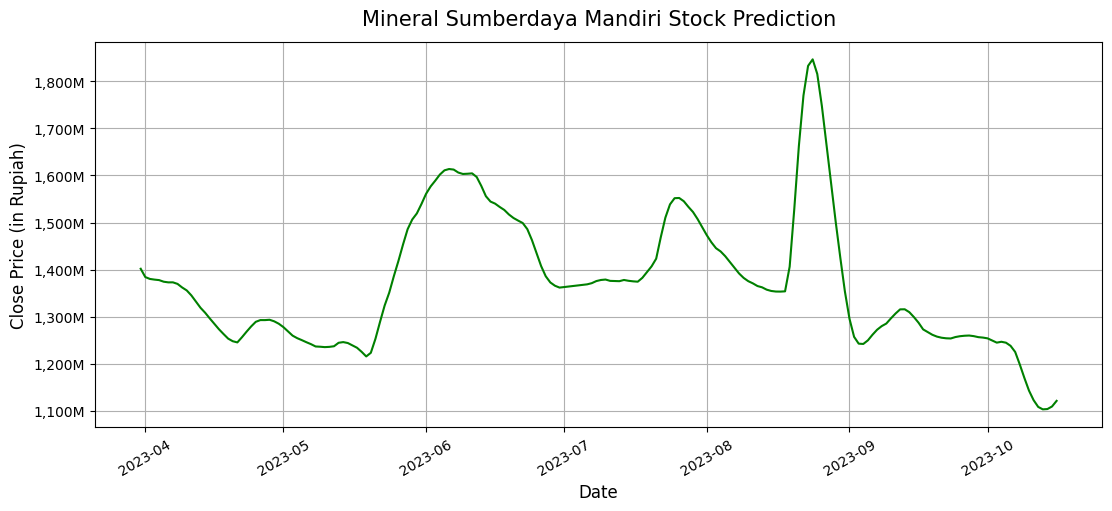

In [24]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [25]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 23s 618ms/step - loss: 0.0235 - val_loss: 0.1110
Epoch 2/10
24/24 [==============================] - 15s 623ms/step - loss: 0.0230 - val_loss: 0.1097
Epoch 3/10
24/24 [==============================] - 12s 520ms/step - loss: 0.0228 - val_loss: 0.1084
Epoch 4/10
24/24 [==============================] - 13s 549ms/step - loss: 0.0225 - val_loss: 0.1071
Epoch 5/10
24/24 [==============================] - 12s 506ms/step - loss: 0.0219 - val_loss: 0.1058
Epoch 6/10
24/24 [==============================] - 13s 525ms/step - loss: 0.0217 - val_loss: 0.1045
Epoch 7/10
24/24 [==============================] - 13s 530ms/step - loss: 0.0217 - val_loss: 0.1032
Epoch 8/10
24/24 [==============================] - 14s 567ms/step - loss: 0.0212 - val_loss: 0.1019
Epoch 9/10
24/24 [==============================] - 12s 508ms/step - loss: 0.0209 - val_loss: 0.1006
Epoch 10/10
24/24 [==============================] - 12s 511ms/step - loss: 0.0204 - val_lo

In [26]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.1309438
Mean Absolute Percentage Error (MAPE): 0.86957
Root Mean Squared Error (RMSE): 0.13243
Mean Squared Error (MSE): 0.0175384
R-Squared (R2): -41.881434
T-Statistic 0.6386
P-Value 3.71094710100169e-22
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 36ms/step


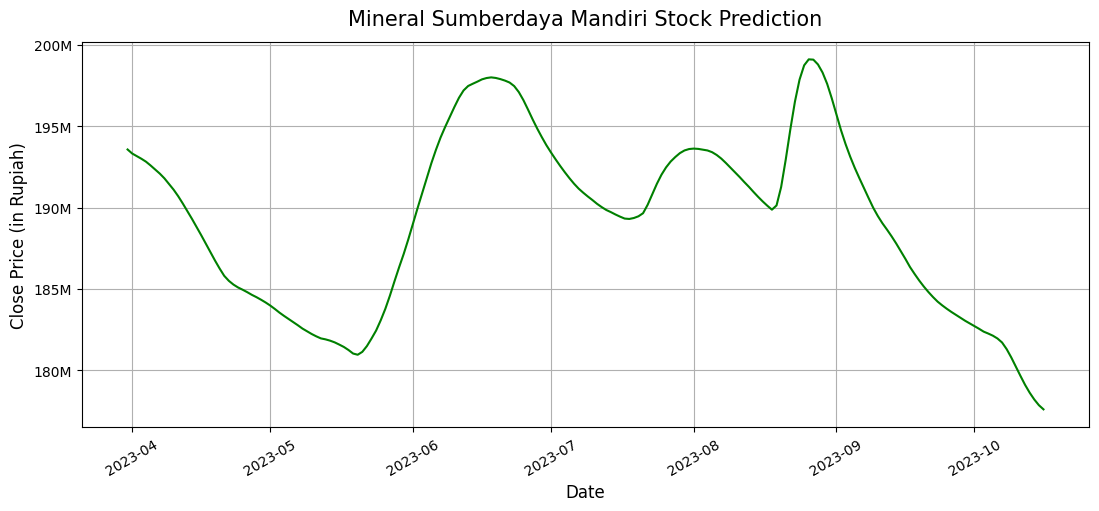

In [27]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [28]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 20s 557ms/step - loss: 0.0168 - val_loss: 0.0621
Epoch 2/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0144 - val_loss: 0.0571
Epoch 3/10
24/24 [==============================] - 9s 380ms/step - loss: 0.0135 - val_loss: 0.0565
Epoch 4/10
24/24 [==============================] - 9s 371ms/step - loss: 0.0128 - val_loss: 0.0538
Epoch 5/10
24/24 [==============================] - 9s 390ms/step - loss: 0.0122 - val_loss: 0.0490
Epoch 6/10
24/24 [==============================] - 9s 373ms/step - loss: 0.0114 - val_loss: 0.0447
Epoch 7/10
24/24 [==============================] - 9s 368ms/step - loss: 0.0106 - val_loss: 0.0420
Epoch 8/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0099 - val_loss: 0.0392
Epoch 9/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0092 - val_loss: 0.0362
Epoch 10/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0088 - val_loss: 0.

In [29]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 35ms/step
Mean Absolute Error (MAE): 0.0366781
Mean Absolute Percentage Error (MAPE): 0.23496
Root Mean Squared Error (RMSE): 0.04049
Mean Squared Error (MSE): 0.0016391
R-Squared (R2): -3.007672
T-Statistic 0.6879
P-Value 9.540103417947081e-21
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 37ms/step


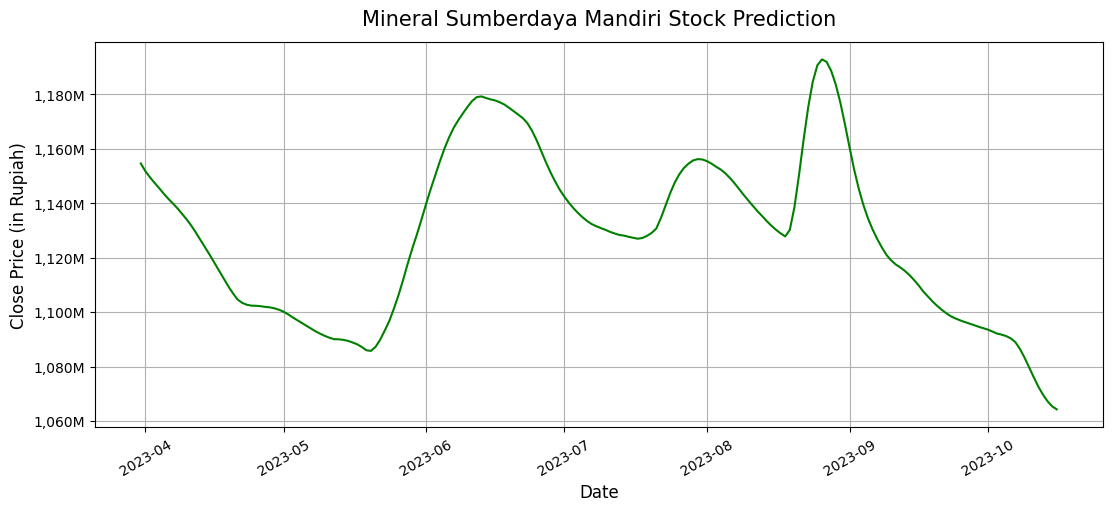

In [30]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [31]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 22s 645ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 2/10
24/24 [==============================] - 15s 627ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 3/10
24/24 [==============================] - 17s 725ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 4/10
24/24 [==============================] - 16s 645ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 5/10
24/24 [==============================] - 15s 612ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 16s 680ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 7/10
24/24 [==============================] - 16s 663ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 8/10
24/24 [==============================] - 14s 605ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 15s 642ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 10/10
24/24 [==============================] - 15s 609ms/step - loss: 0.0011 - val_lo

In [32]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.014198
Mean Absolute Percentage Error (MAPE): 0.09344
Root Mean Squared Error (RMSE): 0.02014
Mean Squared Error (MSE): 0.0004055
R-Squared (R2): 0.008542
T-Statistic 0.8725
P-Value 3.2371219420290753e-13
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 39ms/step


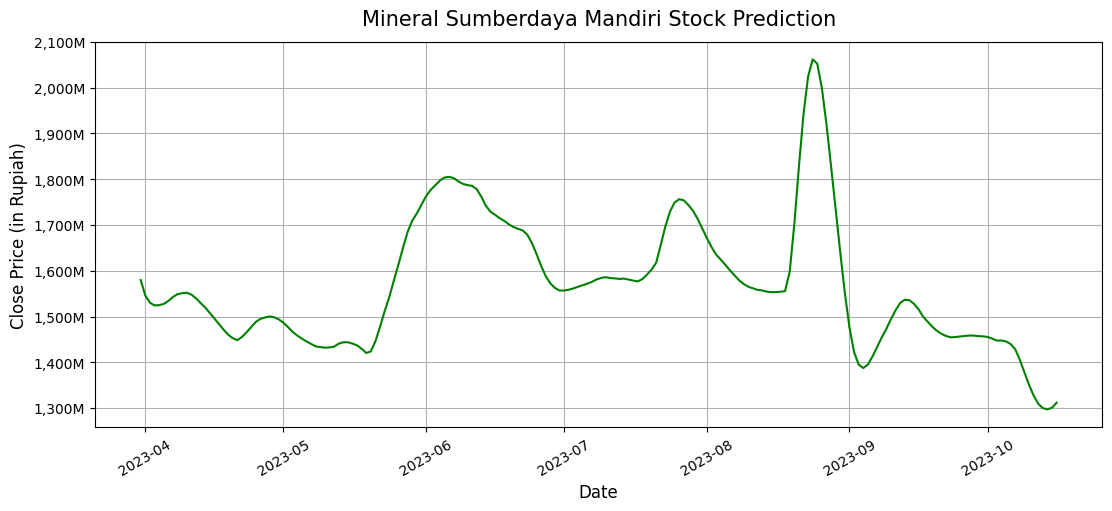

In [33]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [34]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 21s 608ms/step - loss: 0.0058 - val_loss: 0.0092
Epoch 2/10
24/24 [==============================] - 12s 498ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 3/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 4/10
24/24 [==============================] - 12s 485ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 12s 482ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 6/10
24/24 [==============================] - 12s 500ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 8/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 11s 479ms/step - loss: 9.2757e-04 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 11s 475ms/step - loss: 8.9827e-04 

In [35]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0096447
Mean Absolute Percentage Error (MAPE): 0.06108
Root Mean Squared Error (RMSE): 0.0156
Mean Squared Error (MSE): 0.0002435
R-Squared (R2): 0.404635
T-Statistic 0.8823
P-Value 1.236721120477513e-12
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 37ms/step


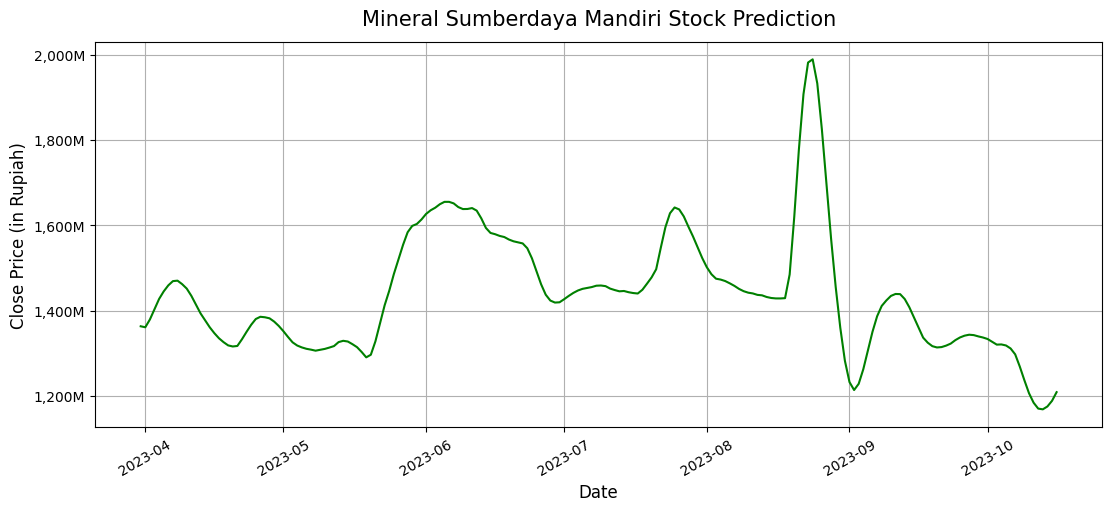

In [36]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [37]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 19s 531ms/step - loss: 0.0184 - val_loss: 0.0799
Epoch 2/10
24/24 [==============================] - 8s 354ms/step - loss: 0.0150 - val_loss: 0.0691
Epoch 3/10
24/24 [==============================] - 9s 361ms/step - loss: 0.0136 - val_loss: 0.0623
Epoch 4/10
24/24 [==============================] - 8s 354ms/step - loss: 0.0129 - val_loss: 0.0578
Epoch 5/10
24/24 [==============================] - 8s 354ms/step - loss: 0.0124 - val_loss: 0.0548
Epoch 6/10
24/24 [==============================] - 9s 361ms/step - loss: 0.0120 - val_loss: 0.0525
Epoch 7/10
24/24 [==============================] - 9s 364ms/step - loss: 0.0119 - val_loss: 0.0507
Epoch 8/10
24/24 [==============================] - 9s 382ms/step - loss: 0.0117 - val_loss: 0.0495
Epoch 9/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0115 - val_loss: 0.0484
Epoch 10/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0112 - val_loss: 0.04

In [38]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0450885
Mean Absolute Percentage Error (MAPE): 0.28978
Root Mean Squared Error (RMSE): 0.04881
Mean Squared Error (MSE): 0.0023827
R-Squared (R2): -4.825618
T-Statistic 0.7157
P-Value 7.113402362430557e-20
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 46ms/step


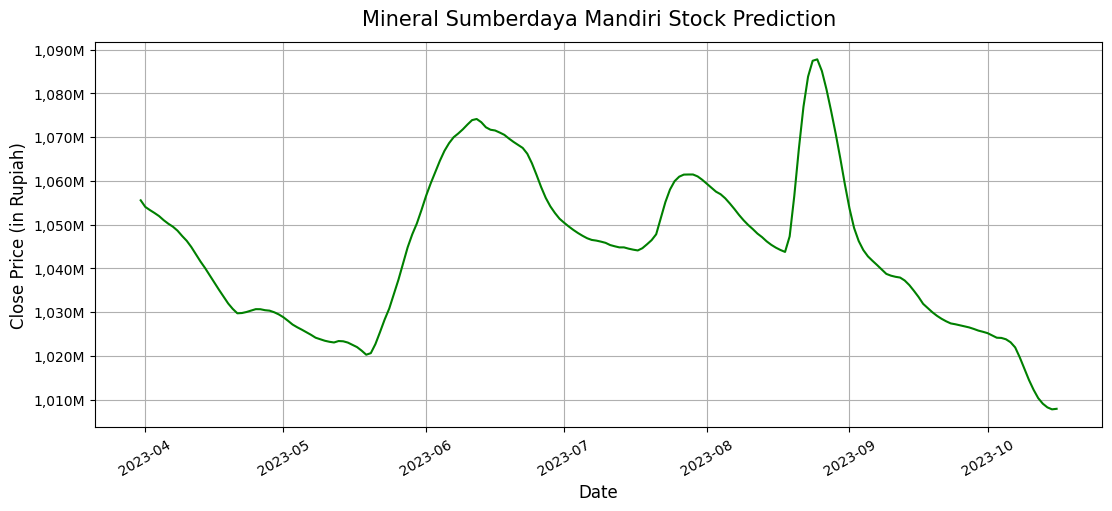

In [39]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [40]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 25s 691ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 2/10
24/24 [==============================] - 16s 655ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 3/10
24/24 [==============================] - 17s 716ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 4/10
24/24 [==============================] - 16s 664ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 5/10
24/24 [==============================] - 15s 634ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 17s 693ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 17s 719ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 16s 666ms/step - loss: 9.9011e-04 - val_loss: 0.0034
Epoch 9/10
24/24 [==============================] - 15s 645ms/step - loss: 9.6793e-04 - val_loss: 0.0030
Epoch 10/10
24/24 [==============================] - 16s 651ms/step - loss: 9.5473e

In [41]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.0093561
Mean Absolute Percentage Error (MAPE): 0.05914
Root Mean Squared Error (RMSE): 0.01514
Mean Squared Error (MSE): 0.0002292
R-Squared (R2): 0.439521
T-Statistic 0.8804
P-Value 9.501181308727014e-13
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 58ms/step


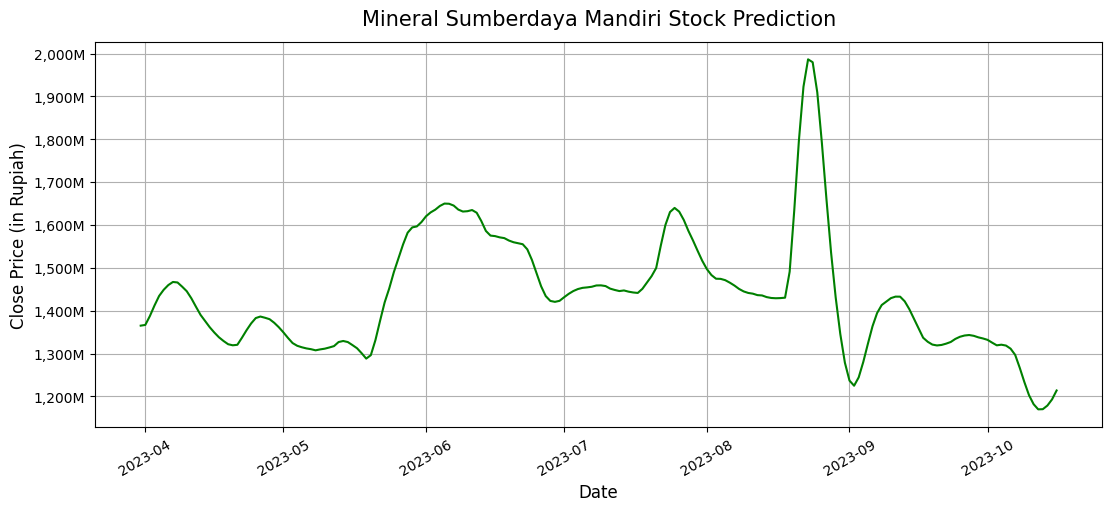

In [42]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [43]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 24s 723ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 2/10
24/24 [==============================] - 14s 603ms/step - loss: 0.0026 - val_loss: 0.0062
Epoch 3/10
24/24 [==============================] - 16s 652ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 16s 649ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 5/10
24/24 [==============================] - 16s 671ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 6/10
24/24 [==============================] - 17s 706ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 7/10
24/24 [==============================] - 16s 680ms/step - loss: 0.0015 - val_loss: 0.0067
Epoch 8/10
24/24 [==============================] - 17s 729ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 16s 684ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 10/10
24/24 [==============================] - 16s 682ms/step - loss: 0.0012 - val_lo

In [44]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 57ms/step
Mean Absolute Error (MAE): 0.0214569
Mean Absolute Percentage Error (MAPE): 0.14131
Root Mean Squared Error (RMSE): 0.02575
Mean Squared Error (MSE): 0.0006629
R-Squared (R2): -0.620854
T-Statistic 0.8809
P-Value 1.029378622272037e-12
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 55ms/step


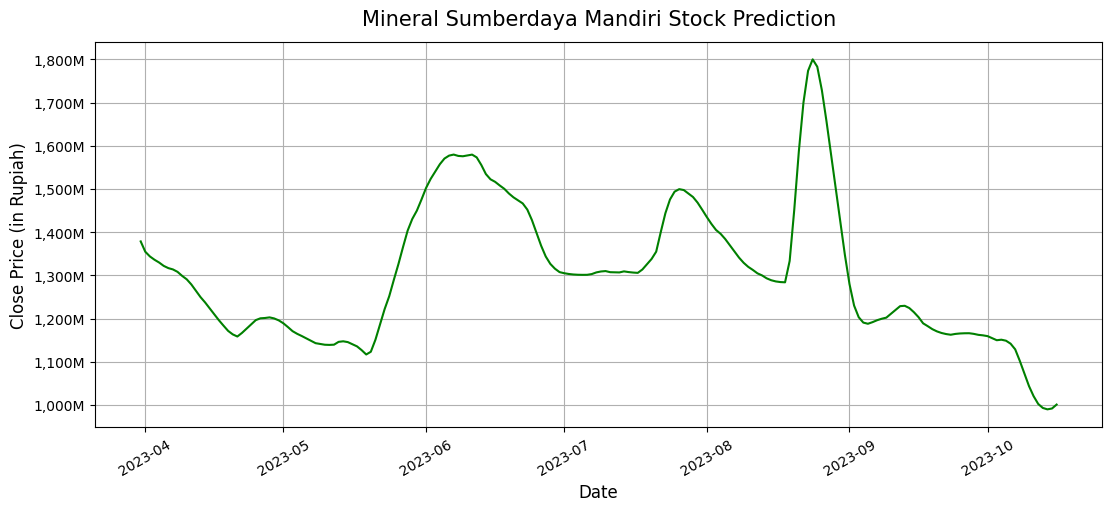

In [45]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [46]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 25s 738ms/step - loss: 0.0234 - val_loss: 0.1111
Epoch 2/10
24/24 [==============================] - 16s 660ms/step - loss: 0.0231 - val_loss: 0.1101
Epoch 3/10
24/24 [==============================] - 17s 713ms/step - loss: 0.0230 - val_loss: 0.1091
Epoch 4/10
24/24 [==============================] - 15s 639ms/step - loss: 0.0227 - val_loss: 0.1080
Epoch 5/10
24/24 [==============================] - 16s 671ms/step - loss: 0.0223 - val_loss: 0.1070
Epoch 6/10
24/24 [==============================] - 16s 683ms/step - loss: 0.0221 - val_loss: 0.1059
Epoch 7/10
24/24 [==============================] - 15s 635ms/step - loss: 0.0219 - val_loss: 0.1049
Epoch 8/10
24/24 [==============================] - 16s 657ms/step - loss: 0.0217 - val_loss: 0.1038
Epoch 9/10
24/24 [==============================] - 15s 645ms/step - loss: 0.0215 - val_loss: 0.1028
Epoch 10/10
24/24 [==============================] - 16s 674ms/step - loss: 0.0212 - val_lo

In [47]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.1337761
Mean Absolute Percentage Error (MAPE): 0.88895
Root Mean Squared Error (RMSE): 0.13521
Mean Squared Error (MSE): 0.0182816
R-Squared (R2): -43.698513
T-Statistic 0.8294
P-Value 1.844710492419541e-15
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 54ms/step


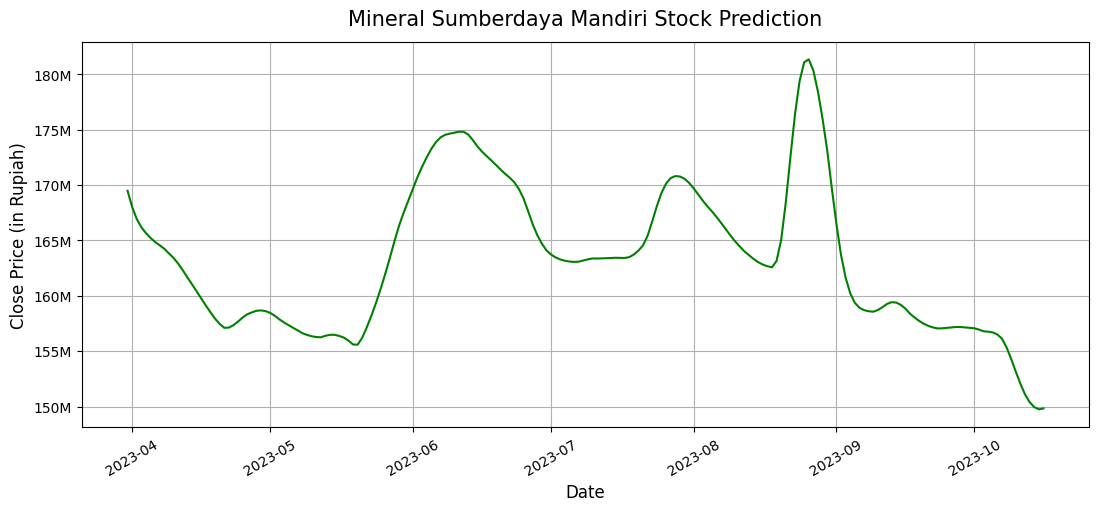

In [48]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [49]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 24s 748ms/step - loss: 0.0172 - val_loss: 0.0662
Epoch 2/10
24/24 [==============================] - 16s 678ms/step - loss: 0.0132 - val_loss: 0.0550
Epoch 3/10
24/24 [==============================] - 17s 703ms/step - loss: 0.0124 - val_loss: 0.0509
Epoch 4/10
24/24 [==============================] - 17s 700ms/step - loss: 0.0115 - val_loss: 0.0465
Epoch 5/10
24/24 [==============================] - 16s 681ms/step - loss: 0.0110 - val_loss: 0.0439
Epoch 6/10
24/24 [==============================] - 16s 678ms/step - loss: 0.0107 - val_loss: 0.0422
Epoch 7/10
24/24 [==============================] - 17s 714ms/step - loss: 0.0103 - val_loss: 0.0395
Epoch 8/10
24/24 [==============================] - 17s 698ms/step - loss: 0.0098 - val_loss: 0.0377
Epoch 9/10
24/24 [==============================] - 16s 673ms/step - loss: 0.0093 - val_loss: 0.0352
Epoch 10/10
24/24 [==============================] - 16s 685ms/step - loss: 0.0089 - val_lo

In [50]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 59ms/step
Mean Absolute Error (MAE): 0.0340376
Mean Absolute Percentage Error (MAPE): 0.2181
Root Mean Squared Error (RMSE): 0.03777
Mean Squared Error (MSE): 0.0014268
R-Squared (R2): -2.488517
T-Statistic 0.6731
P-Value 3.4748031919891394e-21
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 56ms/step


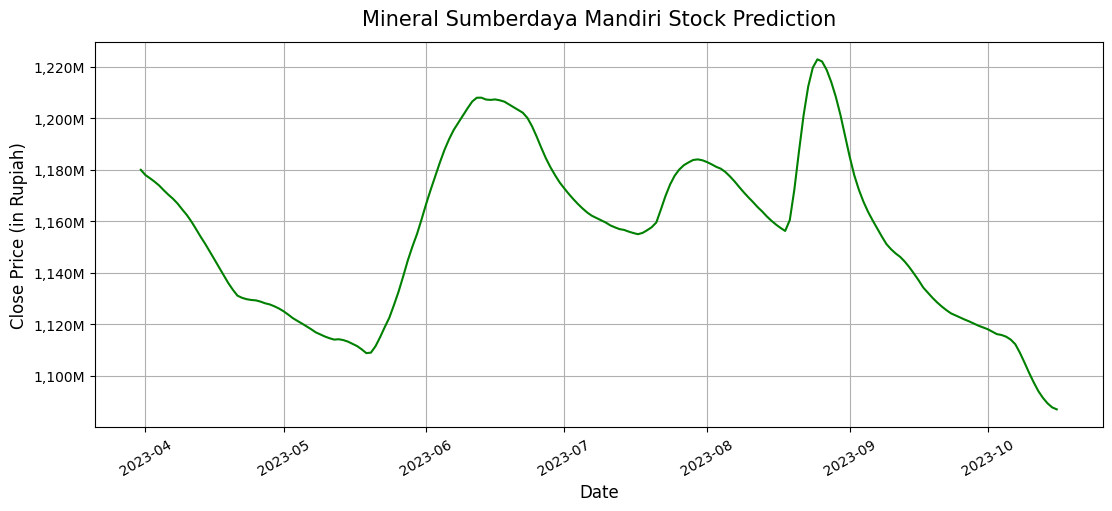

In [51]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [52]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 24s 677ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 2/10
24/24 [==============================] - 15s 613ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 3/10
24/24 [==============================] - 14s 603ms/step - loss: 0.0018 - val_loss: 0.0060
Epoch 4/10
24/24 [==============================] - 14s 578ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 5/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 6/10
24/24 [==============================] - 15s 613ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 14s 584ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 8/10
24/24 [==============================] - 15s 633ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 14s 605ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 10/10
24/24 [==============================] - 14s 596ms/step - loss: 0.0011 - val_lo

In [53]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.0105778
Mean Absolute Percentage Error (MAPE): 0.06843
Root Mean Squared Error (RMSE): 0.01786
Mean Squared Error (MSE): 0.0003189
R-Squared (R2): 0.220334
T-Statistic 0.8705
P-Value 2.480900142438902e-13
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 45ms/step


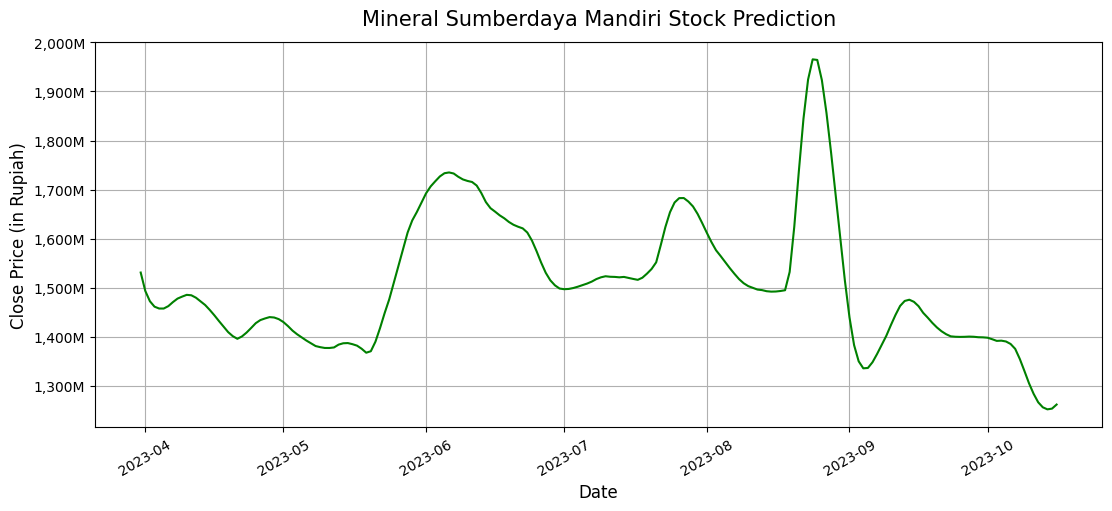

In [54]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [55]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 25s 748ms/step - loss: 0.0489 - val_loss: 0.0569
Epoch 2/10
24/24 [==============================] - 14s 585ms/step - loss: 0.0075 - val_loss: 0.0135
Epoch 3/10
24/24 [==============================] - 13s 560ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 4/10
24/24 [==============================] - 14s 576ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 5/10
24/24 [==============================] - 13s 564ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 6/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 7/10
24/24 [==============================] - 13s 557ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 8/10
24/24 [==============================] - 13s 556ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 10/10
24/24 [==============================] - 16s 658ms/step - loss: 0.0012 - val_lo

In [56]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.0170219
Mean Absolute Percentage Error (MAPE): 0.11304
Root Mean Squared Error (RMSE): 0.02281
Mean Squared Error (MSE): 0.0005201
R-Squared (R2): -0.271577
T-Statistic 0.8635
P-Value 1.0094725890700401e-13
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 40ms/step


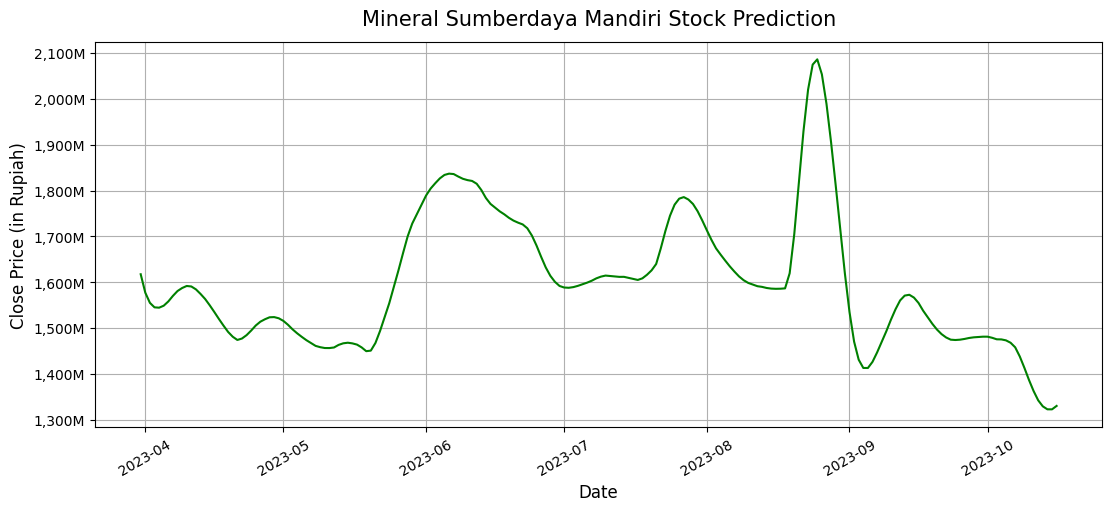

In [57]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [58]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 23s 662ms/step - loss: 0.2164 - val_loss: 0.3834
Epoch 2/10
24/24 [==============================] - 14s 570ms/step - loss: 0.1346 - val_loss: 0.2990
Epoch 3/10
24/24 [==============================] - 13s 562ms/step - loss: 0.0954 - val_loss: 0.2452
Epoch 4/10
24/24 [==============================] - 15s 605ms/step - loss: 0.0711 - val_loss: 0.2072
Epoch 5/10
24/24 [==============================] - 14s 588ms/step - loss: 0.0550 - val_loss: 0.1788
Epoch 6/10
24/24 [==============================] - 15s 624ms/step - loss: 0.0438 - val_loss: 0.1570
Epoch 7/10
24/24 [==============================] - 17s 701ms/step - loss: 0.0358 - val_loss: 0.1397
Epoch 8/10
24/24 [==============================] - 15s 606ms/step - loss: 0.0300 - val_loss: 0.1260
Epoch 9/10
24/24 [==============================] - 14s 596ms/step - loss: 0.0259 - val_loss: 0.1150
Epoch 10/10
24/24 [==============================] - 16s 657ms/step - loss: 0.0228 - val_lo

In [59]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.133864
Mean Absolute Percentage Error (MAPE): 0.88918
Root Mean Squared Error (RMSE): 0.13536
Mean Squared Error (MSE): 0.0183219
R-Squared (R2): -43.797219
T-Statistic 0.743
P-Value 5.920985191036597e-19
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 51ms/step


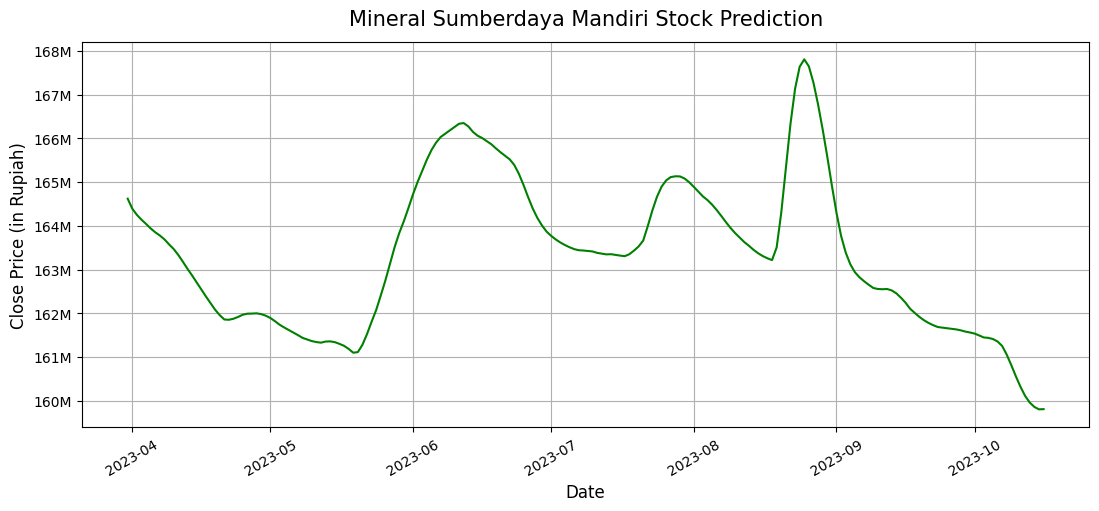

In [60]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [61]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 24s 620ms/step - loss: 0.1202 - val_loss: 0.0526
Epoch 2/10
24/24 [==============================] - 13s 539ms/step - loss: 0.0133 - val_loss: 0.0139
Epoch 3/10
24/24 [==============================] - 14s 586ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 4/10
24/24 [==============================] - 13s 562ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 5/10
24/24 [==============================] - 14s 584ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 6/10
24/24 [==============================] - 13s 560ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 7/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 8/10
24/24 [==============================] - 12s 512ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 9/10
24/24 [==============================] - 13s 554ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 14s 582ms/step - loss: 0.0024 - val_lo

In [62]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 46ms/step
Mean Absolute Error (MAE): 0.0260413
Mean Absolute Percentage Error (MAPE): 0.17744
Root Mean Squared Error (RMSE): 0.03177
Mean Squared Error (MSE): 0.0010096
R-Squared (R2): -1.468549
T-Statistic 0.7939
P-Value 5.043666287104102e-17
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 44ms/step


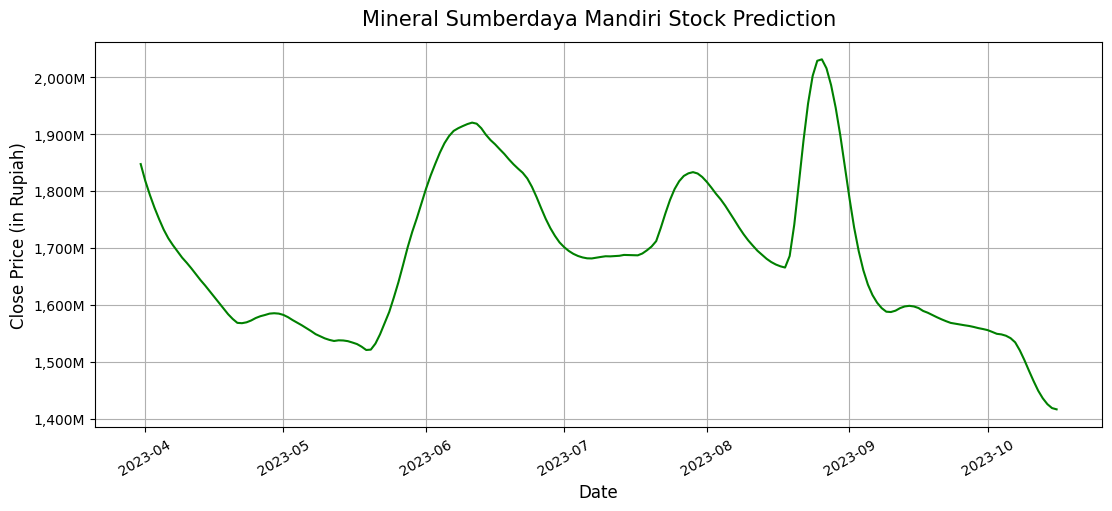

In [63]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [64]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 15s 327ms/step - loss: 0.0132 - val_loss: 0.0075
Epoch 2/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 3/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 4/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 5/10
24/24 [==============================] - 7s 309ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 6/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 7/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 8/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 9/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 10/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0019 - val_loss: 0.004

In [65]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0209032
Mean Absolute Percentage Error (MAPE): 0.13562
Root Mean Squared Error (RMSE): 0.02557
Mean Squared Error (MSE): 0.0006538
R-Squared (R2): -0.598438
T-Statistic 0.8408
P-Value 6.5542223612411604e-15
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 39ms/step


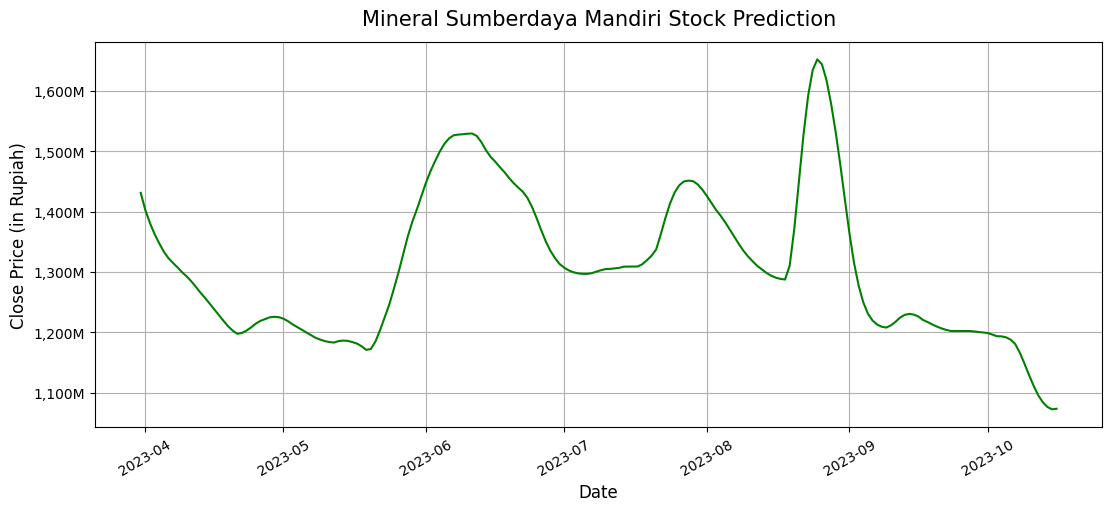

In [66]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [67]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 18s 503ms/step - loss: 0.3665 - val_loss: 0.1485
Epoch 2/10
24/24 [==============================] - 11s 469ms/step - loss: 0.3655 - val_loss: 0.1477
Epoch 3/10
24/24 [==============================] - 11s 464ms/step - loss: 0.3643 - val_loss: 0.1470
Epoch 4/10
24/24 [==============================] - 11s 473ms/step - loss: 0.3632 - val_loss: 0.1462
Epoch 5/10
24/24 [==============================] - 11s 464ms/step - loss: 0.3620 - val_loss: 0.1453
Epoch 6/10
24/24 [==============================] - 11s 459ms/step - loss: 0.3608 - val_loss: 0.1445
Epoch 7/10
24/24 [==============================] - 12s 506ms/step - loss: 0.3596 - val_loss: 0.1437
Epoch 8/10
24/24 [==============================] - 13s 561ms/step - loss: 0.3584 - val_loss: 0.1429
Epoch 9/10
24/24 [==============================] - 12s 515ms/step - loss: 0.3572 - val_loss: 0.1420
Epoch 10/10
24/24 [==============================] - 11s 476ms/step - loss: 0.3560 - val_lo

In [68]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 0.5347348
Mean Absolute Percentage Error (MAPE): 3.63405
Root Mean Squared Error (RMSE): 0.53511
Mean Squared Error (MSE): 0.2863423
R-Squared (R2): -699.108328
T-Statistic 0.7084
P-Value 4.1406021595027785e-20
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 41ms/step


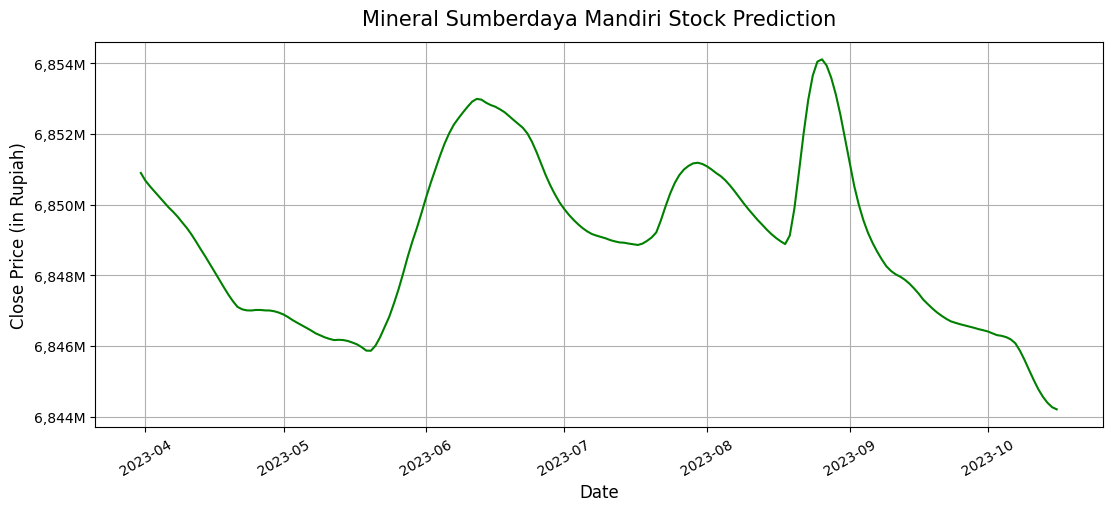

In [69]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [70]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 21s 597ms/step - loss: 0.0229 - val_loss: 0.0669
Epoch 2/10
24/24 [==============================] - 13s 552ms/step - loss: 0.0158 - val_loss: 0.0657
Epoch 3/10
24/24 [==============================] - 13s 538ms/step - loss: 0.0157 - val_loss: 0.0687
Epoch 4/10
24/24 [==============================] - 12s 499ms/step - loss: 0.0157 - val_loss: 0.0619
Epoch 5/10
24/24 [==============================] - 13s 526ms/step - loss: 0.0155 - val_loss: 0.0694
Epoch 6/10
24/24 [==============================] - 13s 533ms/step - loss: 0.0154 - val_loss: 0.0667
Epoch 7/10
24/24 [==============================] - 13s 540ms/step - loss: 0.0154 - val_loss: 0.0620
Epoch 8/10
24/24 [==============================] - 13s 535ms/step - loss: 0.0153 - val_loss: 0.0650
Epoch 9/10
24/24 [==============================] - 13s 521ms/step - loss: 0.0153 - val_loss: 0.0635
Epoch 10/10
24/24 [==============================] - 13s 540ms/step - loss: 0.0152 - val_lo

In [71]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 51ms/step
Mean Absolute Error (MAE): 0.0472563
Mean Absolute Percentage Error (MAPE): 0.30298
Root Mean Squared Error (RMSE): 0.05148
Mean Squared Error (MSE): 0.0026498
R-Squared (R2): -5.47868
T-Statistic 0.7745
P-Value 8.47223695103555e-18
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 47ms/step


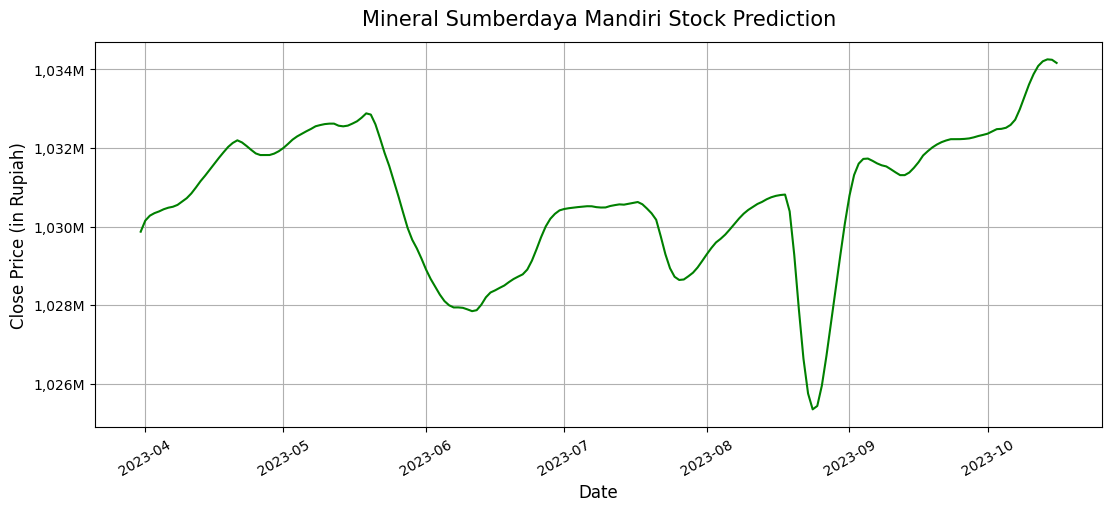

In [72]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [73]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 19s 510ms/step - loss: 0.0092 - val_loss: 0.0063
Epoch 2/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 3/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 4/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 5/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 6/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 7/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 9/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 10/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0012 - val_lo

In [74]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.0130385
Mean Absolute Percentage Error (MAPE): 0.08356
Root Mean Squared Error (RMSE): 0.01982
Mean Squared Error (MSE): 0.0003929
R-Squared (R2): 0.039462
T-Statistic 0.8376
P-Value 4.54035578936491e-15
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 39ms/step


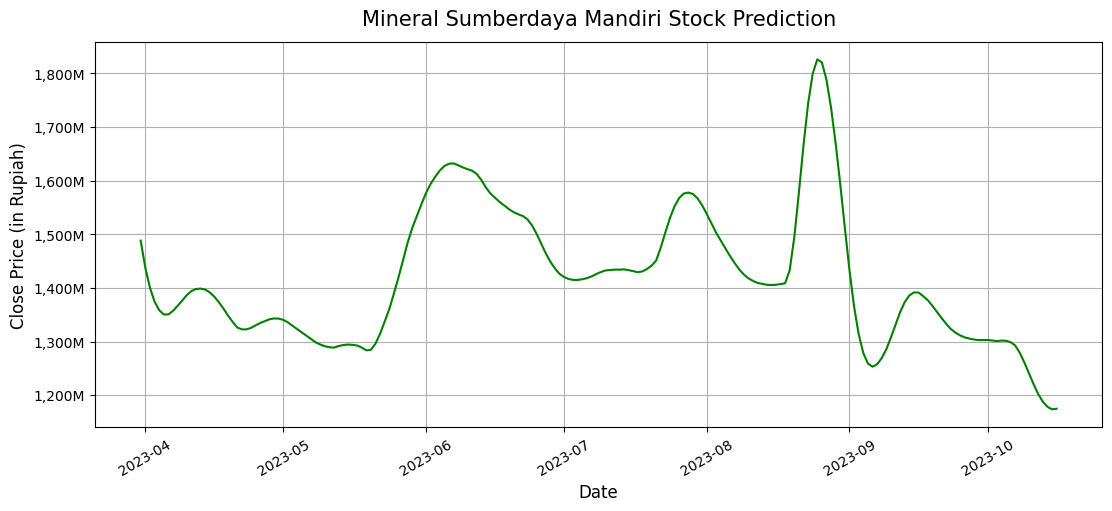

In [75]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [76]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 17s 455ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 2/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 3/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 4/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 5/10
24/24 [==============================] - 10s 436ms/step - loss: 8.0849e-04 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 11s 443ms/step - loss: 9.0018e-04 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 10s 433ms/step - loss: 8.6367e-04 - val_loss: 0.0032
Epoch 9/10
24/24 [==============================] - 11s 446ms/step - loss: 9.1719e-04 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 11s 452ms/step - loss:

In [77]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 47ms/step
Mean Absolute Error (MAE): 0.0095172
Mean Absolute Percentage Error (MAPE): 0.06154
Root Mean Squared Error (RMSE): 0.01448
Mean Squared Error (MSE): 0.0002097
R-Squared (R2): 0.487189
T-Statistic 0.8816
P-Value 1.1275146398134761e-12
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 48ms/step


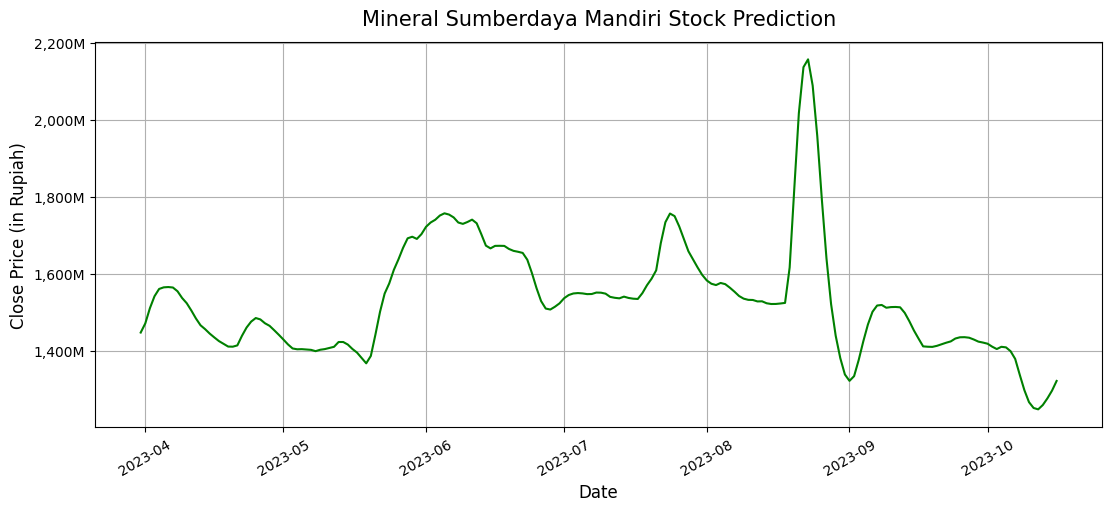

In [78]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [79]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 17s 418ms/step - loss: 0.0236 - val_loss: 0.0912
Epoch 2/10
24/24 [==============================] - 8s 344ms/step - loss: 0.0190 - val_loss: 0.0779
Epoch 3/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0179 - val_loss: 0.0737
Epoch 4/10
24/24 [==============================] - 8s 348ms/step - loss: 0.0173 - val_loss: 0.0683
Epoch 5/10
24/24 [==============================] - 9s 358ms/step - loss: 0.0160 - val_loss: 0.0657
Epoch 6/10
24/24 [==============================] - 9s 357ms/step - loss: 0.0152 - val_loss: 0.0632
Epoch 7/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0147 - val_loss: 0.0580
Epoch 8/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0137 - val_loss: 0.0559
Epoch 9/10
24/24 [==============================] - 8s 349ms/step - loss: 0.0131 - val_loss: 0.0526
Epoch 10/10
24/24 [==============================] - 9s 372ms/step - loss: 0.0122 - val_loss: 0.050

In [80]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.0427988
Mean Absolute Percentage Error (MAPE): 0.27389
Root Mean Squared Error (RMSE): 0.04687
Mean Squared Error (MSE): 0.0021965
R-Squared (R2): -4.370436
T-Statistic 0.6671
P-Value 2.322617944936807e-21
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 51ms/step


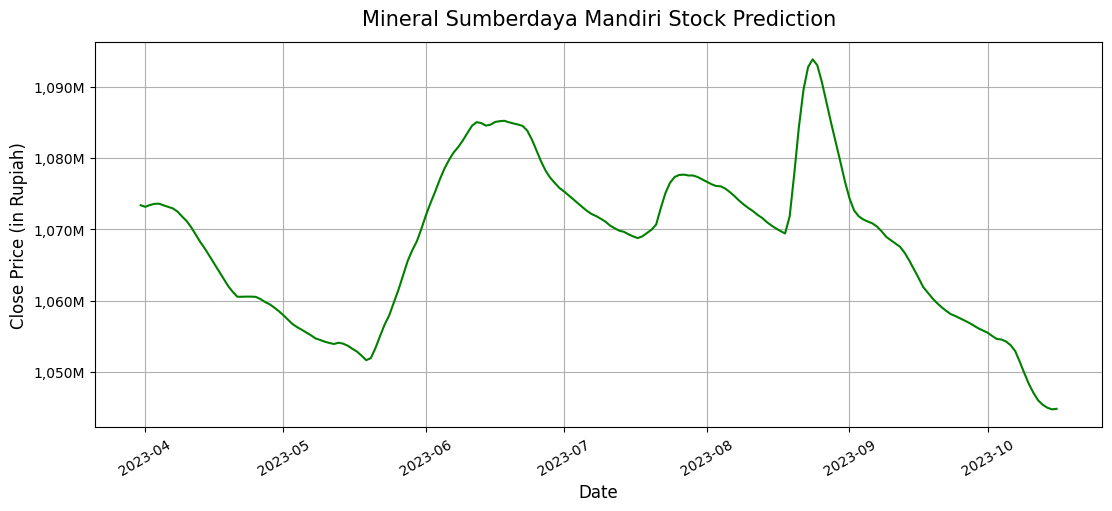

In [81]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [82]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 28s 667ms/step - loss: 0.0048 - val_loss: 0.0065
Epoch 2/10
24/24 [==============================] - 12s 521ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 3/10
24/24 [==============================] - 13s 529ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 13s 533ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 5/10
24/24 [==============================] - 13s 562ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 13s 549ms/step - loss: 8.9521e-04 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 14s 578ms/step - loss: 8.1770e-04 - val_loss: 0.0033
Epoch 8/10
24/24 [==============================] - 13s 535ms/step - loss: 8.6729e-04 - val_loss: 0.0025
Epoch 9/10
24/24 [==============================] - 14s 570ms/step - loss: 7.9734e-04 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 13s 552ms/step - loss:

In [83]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0092534
Mean Absolute Percentage Error (MAPE): 0.05912
Root Mean Squared Error (RMSE): 0.01484
Mean Squared Error (MSE): 0.0002202
R-Squared (R2): 0.461606
T-Statistic 0.8796
P-Value 8.52318595475493e-13
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 43ms/step


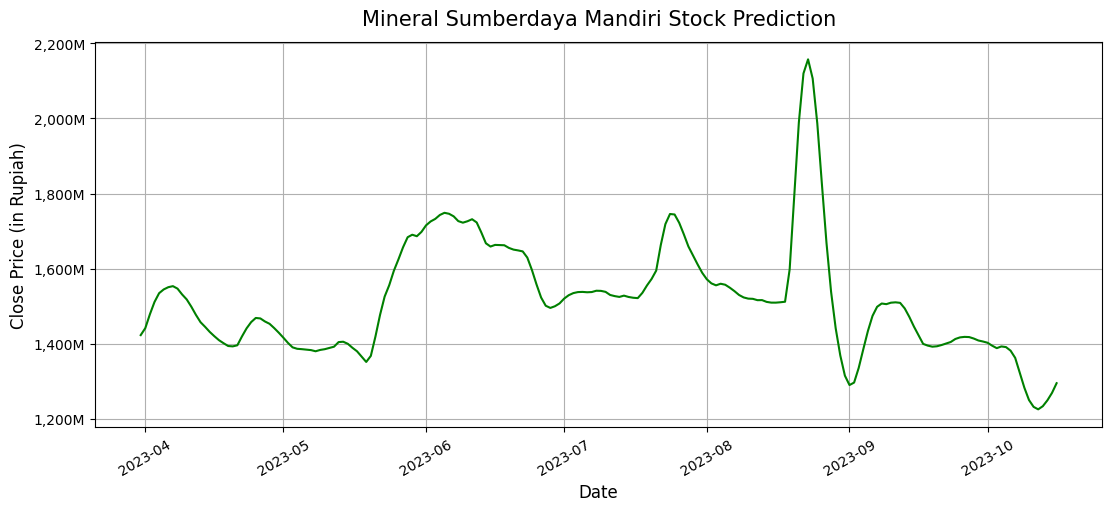

In [84]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [85]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 18s 467ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 2/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 3/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 4/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 5/10
24/24 [==============================] - 12s 500ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 7/10
24/24 [==============================] - 12s 507ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 8/10
24/24 [==============================] - 12s 496ms/step - loss: 0.0014 - val_loss: 0.0054
Epoch 9/10
24/24 [==============================] - 12s 509ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 10/10
24/24 [==============================] - 13s 528ms/step - loss: 0.0013 - val_lo

In [86]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 53ms/step
Mean Absolute Error (MAE): 0.0174672
Mean Absolute Percentage Error (MAPE): 0.11386
Root Mean Squared Error (RMSE): 0.02169
Mean Squared Error (MSE): 0.0004704
R-Squared (R2): -0.150224
T-Statistic 0.8721
P-Value 3.0775013613870694e-13
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 48ms/step


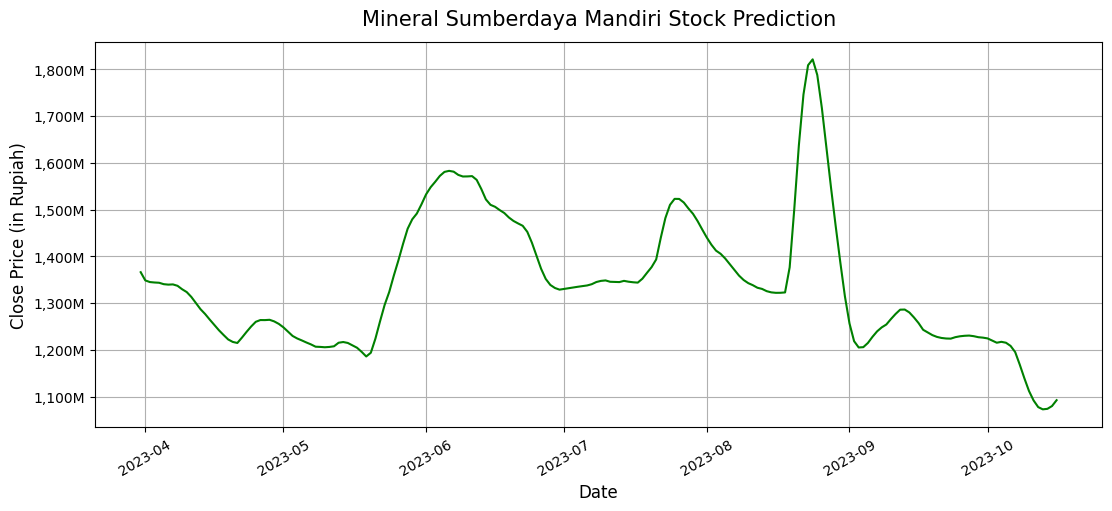

In [87]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [88]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 17s 426ms/step - loss: 0.0223 - val_loss: 0.1063
Epoch 2/10
24/24 [==============================] - 12s 498ms/step - loss: 0.0221 - val_loss: 0.1050
Epoch 3/10
24/24 [==============================] - 12s 495ms/step - loss: 0.0220 - val_loss: 0.1036
Epoch 4/10
24/24 [==============================] - 12s 502ms/step - loss: 0.0214 - val_loss: 0.1023
Epoch 5/10
24/24 [==============================] - 12s 517ms/step - loss: 0.0210 - val_loss: 0.1010
Epoch 6/10
24/24 [==============================] - 12s 486ms/step - loss: 0.0206 - val_loss: 0.0997
Epoch 7/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0204 - val_loss: 0.0985
Epoch 8/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0201 - val_loss: 0.0972
Epoch 9/10
24/24 [==============================] - 12s 499ms/step - loss: 0.0199 - val_loss: 0.0959
Epoch 10/10
24/24 [==============================] - 12s 502ms/step - loss: 0.0197 - val_lo

In [89]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Error (MAE): 0.127097
Mean Absolute Percentage Error (MAPE): 0.84397
Root Mean Squared Error (RMSE): 0.12856
Mean Squared Error (MSE): 0.0165282
R-Squared (R2): -39.411594
T-Statistic 0.7472
P-Value 8.30557318909834e-19
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 59ms/step


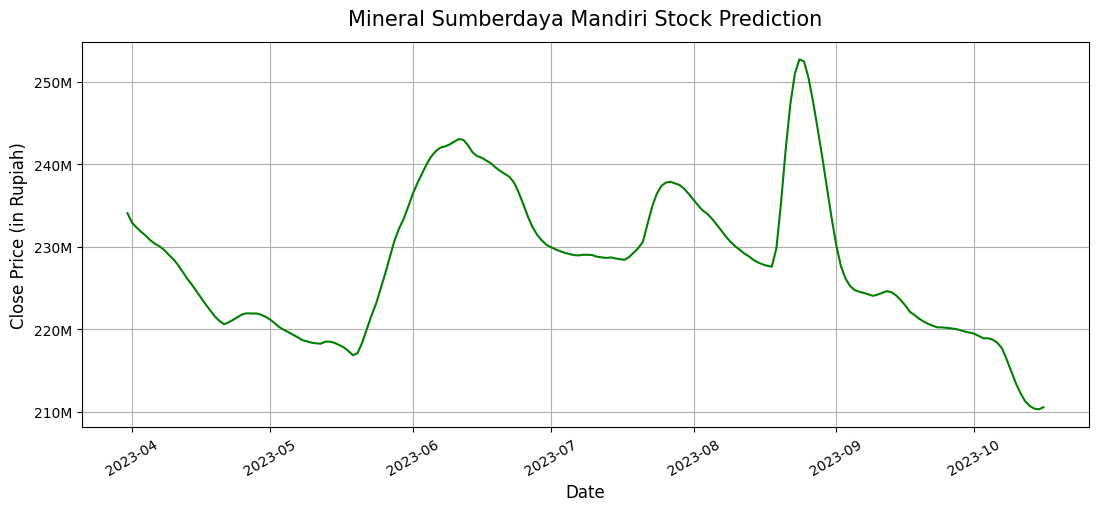

In [90]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [91]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 18s 487ms/step - loss: 0.0141 - val_loss: 0.0508
Epoch 2/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0123 - val_loss: 0.0483
Epoch 3/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0115 - val_loss: 0.0446
Epoch 4/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0106 - val_loss: 0.0423
Epoch 5/10
24/24 [==============================] - 10s 435ms/step - loss: 0.0100 - val_loss: 0.0399
Epoch 6/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0093 - val_loss: 0.0367
Epoch 7/10
24/24 [==============================] - 11s 437ms/step - loss: 0.0088 - val_loss: 0.0355
Epoch 8/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0081 - val_loss: 0.0307
Epoch 9/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0077 - val_loss: 0.0296
Epoch 10/10
24/24 [==============================] - 10s 439ms/step - loss: 0.0072 - val_lo

In [92]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Error (MAE): 0.0313677
Mean Absolute Percentage Error (MAPE): 0.20117
Root Mean Squared Error (RMSE): 0.03516
Mean Squared Error (MSE): 0.001236
R-Squared (R2): -2.022087
T-Statistic 0.6798
P-Value 5.450067681706721e-21
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 44ms/step


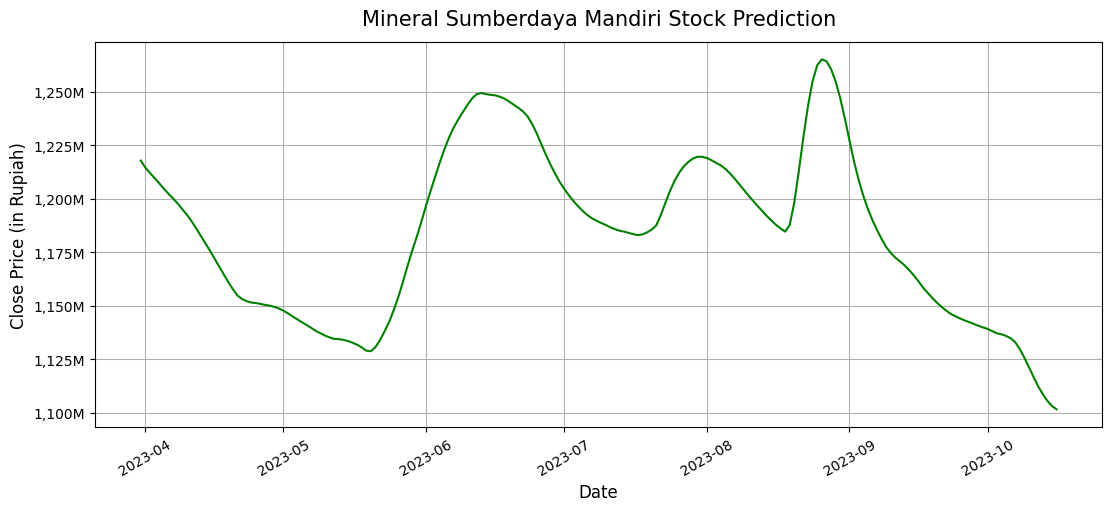

In [93]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [94]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 16s 389ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 2/10
24/24 [==============================] - 8s 319ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 3/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 5/10
24/24 [==============================] - 8s 320ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 6/10
24/24 [==============================] - 8s 320ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 8s 313ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 8/10
24/24 [==============================] - 8s 317ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 9/10
24/24 [==============================] - 8s 317ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 8s 349ms/step - loss: 0.0013 - val_loss: 0.003

In [95]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.0229929
Mean Absolute Percentage Error (MAPE): 0.15456
Root Mean Squared Error (RMSE): 0.0271
Mean Squared Error (MSE): 0.0007342
R-Squared (R2): -0.795035
T-Statistic 0.8631
P-Value 9.601924154866923e-14
Elapsed Time (min): 10.63


7/7 [==============================] - 0s 44ms/step


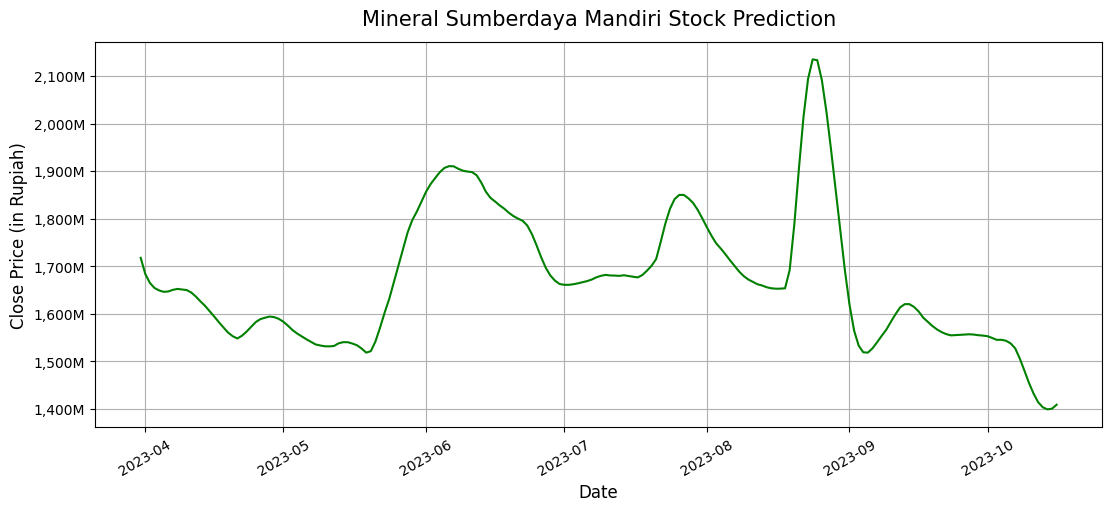

In [96]:
#prediction of LSTM for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [99]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 48ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 46ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 51ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 41ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 44ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 35ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 41ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 58ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 59ms/step
Training

In [100]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                91.76  0.12973   0.86157  0.01721   
           adagrad                 85.07  0.04468   0.28634  0.00237   
           adam                    86.26  0.00816   0.05117  0.00021   
           adamax                  89.77  0.01300   0.08533  0.00038   
           nadam                  109.73  0.01061   0.06815  0.00026   
           rmsprop                 82.59  0.01374   0.08857  0.00035   
           sgd                     85.64  0.02864   0.18307  0.00107   
relu       adadelta                84.41  0.12851   0.85320  0.01690   
           adagrad                 95.27  0.04489   0.28855  0.00236   
           adam                    86.98  0.00946   0.06012  0.00026   
           adamax                 100.16  0.01699   0.11375  0.00056   
           nadam                   95.31  0.00773   0.04870  0.00019   
           rmsprop                 99.15  0.01504   0.10038  0.00040   
           sgd                     92.77  0.03391   0.21704  0.00142   
sigmoid    adadelta               129.29  0.78431   5.28952  0.61555   
           adagrad                109.23  0.68768   4.63617  0.47329   
           adam                   108.98  0.01614   0.10415  0.00044   
           adamax                 118.36  0.05167   0.33333  0.00306   
           nadam                  124.82  0.06300   0.40988  0.00436   
           rmsprop                135.40  0.05067   0.34678  0.00295   
           sgd                    114.27  0.05011   0.32275  0.00290   
tanh       adadelta                97.10  0.10818   0.71684  0.01204   
           adagrad                 95.98  0.03592   0.22970  0.00159   
           adam                    94.44  0.00856   0.05408  0.00019   
           adamax                 118.68  0.01121   0.07292  0.00032   
           nadam                  106.79  0.00830   0.05216  0.00022   
           rmsprop                103.40  0.01345   0.08677  0.00034   
           sgd                    101.64  0.02448   0.15623  0.00083   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   2.534414e-18         -41.09   0.13119     0.760595  
           adagrad    1.429582e-21          -4.80   0.04868     0.659739  
           adam       6.572891e-13           0.48   0.01449     0.877705  
           adamax     1.175979e-13           0.07   0.01949     0.864713  
           nadam      1.405067e-12           0.37   0.01612     0.883158  
           rmsprop    1.707870e-13           0.15   0.01871     0.867607  
           sgd        2.458125e-21          -1.61   0.03271     0.667965  
relu       adadelta   1.028347e-21         -40.32   0.13000     0.654665  
           adagrad    1.888703e-19          -4.77   0.04858     0.728559  
           adam       2.397746e-12           0.37   0.01612     0.886893  
           adamax     1.067171e-15          -0.38   0.02366     0.824336  
           nadam      3.237250e-12           0.53   0.01378     0.888955  
           rmsprop    4.280411e-13           0.02   0.02000     0.874551  
           sgd        5.419574e-20          -2.48   0.03768     0.712068  
sigmoid    adadelta   7.048508e-22       -1504.02   0.78457     0.648776  
           adagrad    3.364369e-22       -1156.19   0.68796     0.637024  
           adam       1.277384e-14          -0.07   0.02098     0.846576  
           adamax     3.383075e-21          -6.48   0.05532     0.672740  
           nadam      4.686832e-21          -9.67   0.06603     0.677561  
           rmsprop    5.917435e-16          -6.20   0.05431     0.818732  
           sgd        4.208345e-15          -6.10   0.05385     0.836892  
tanh       adadelta   1.294270e-19         -28.45   0.10973     0.723643  
           adagrad    7.310326e-21          -2.88   0.03987  

In [101]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
relu       nadam                   95.31  0.00773   0.04870  0.00019   
linear     adam                    86.26  0.00816   0.05117  0.00021   
tanh       nadam                  106.79  0.00830   0.05216  0.00022   
           adam                    94.44  0.00856   0.05408  0.00019   
relu       adam                    86.98  0.00946   0.06012  0.00026   
linear     nadam                  109.73  0.01061   0.06815  0.00026   
tanh       adamax                 118.68  0.01121   0.07292  0.00032   
linear     adamax                  89.77  0.01300   0.08533  0.00038   
tanh       rmsprop                103.40  0.01345   0.08677  0.00034   
linear     rmsprop                 82.59  0.01374   0.08857  0.00035   
relu       rmsprop                 99.15  0.01504   0.10038  0.00040   
sigmoid    adam                   108.98  0.01614   0.10415  0.00044   
relu       adamax                 100.16  0.01699   0.11375  0.00056   
tanh       sgd                    101.64  0.02448   0.15623  0.00083   
linear     sgd                     85.64  0.02864   0.18307  0.00107   
relu       sgd                     92.77  0.03391   0.21704  0.00142   
tanh       adagrad                 95.98  0.03592   0.22970  0.00159   
linear     adagrad                 85.07  0.04468   0.28634  0.00237   
relu       adagrad                 95.27  0.04489   0.28855  0.00236   
sigmoid    sgd                    114.27  0.05011   0.32275  0.00290   
           adamax                 118.36  0.05167   0.33333  0.00306   
           rmsprop                135.40  0.05067   0.34678  0.00295   
           nadam                  124.82  0.06300   0.40988  0.00436   
tanh       adadelta                97.10  0.10818   0.71684  0.01204   
relu       adadelta                84.41  0.12851   0.85320  0.01690   
linear     adadelta                91.76  0.12973   0.86157  0.01721   
sigmoid    adagrad                109.23  0.68768   4.63617  0.47329   
           adadelta               129.29  0.78431   5.28952  0.61555   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
relu       nadam      3.237250e-12           0.53   0.01378     0.888955  
linear     adam       6.572891e-13           0.48   0.01449     0.877705  
tanh       nadam      6.566731e-13           0.47   0.01483     0.877698  
           adam       5.278898e-12           0.53   0.01378     0.892259  
relu       adam       2.397746e-12           0.37   0.01612     0.886893  
linear     nadam      1.405067e-12           0.37   0.01612     0.883158  
tanh       adamax     1.669169e-13           0.21   0.01789     0.867431  
linear     adamax     1.175979e-13           0.07   0.01949     0.864713  
tanh       rmsprop    5.461486e-13           0.17   0.01844     0.876350  
linear     rmsprop    1.707870e-13           0.15   0.01871     0.867607  
relu       rmsprop    4.280411e-13           0.02   0.02000     0.874551  
sigmoid    adam       1.277384e-14          -0.07   0.02098     0.846576  
relu       adamax     1.067171e-15          -0.38   0.02366     0.824336  
tanh       sgd        3.801424e-21          -1.04   0.02881     0.674471  
linear     sgd        2.458125e-21          -1.61   0.03271     0.667965  
relu       sgd        5.419574e-20          -2.48   0.03768     0.712068  
tanh       adagrad    7.310326e-21          -2.88   0.03987     0.684048  
linear     adagrad    1.429582e-21          -4.80   0.04868     0.659739  
relu       adagrad    1.888703e-19          -4.77   0.04858     0.728559  
sigmoid    sgd        4.208345e-15          -6.10   0.05385     0.836892  
           adamax     3.383075e-21          -6.48   0.05532     0.672740  
           rmsprop    5.917435e-16          -6.20   0.05431     0.818732  
           nadam      4.686832e-21          -9.67   0.06603  

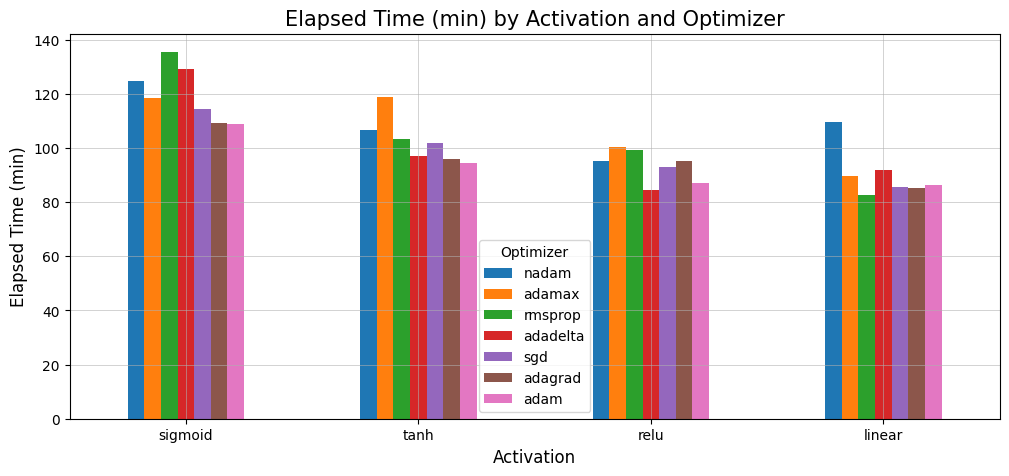

In [102]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

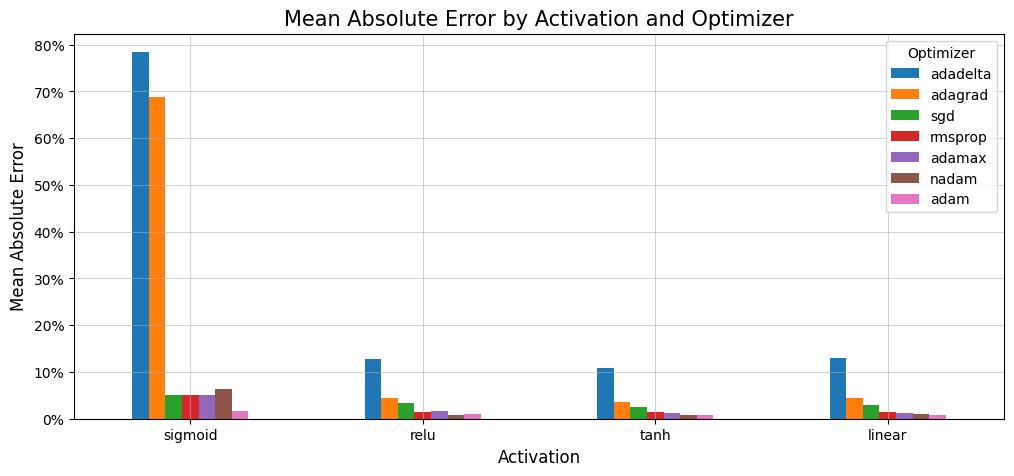

In [103]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

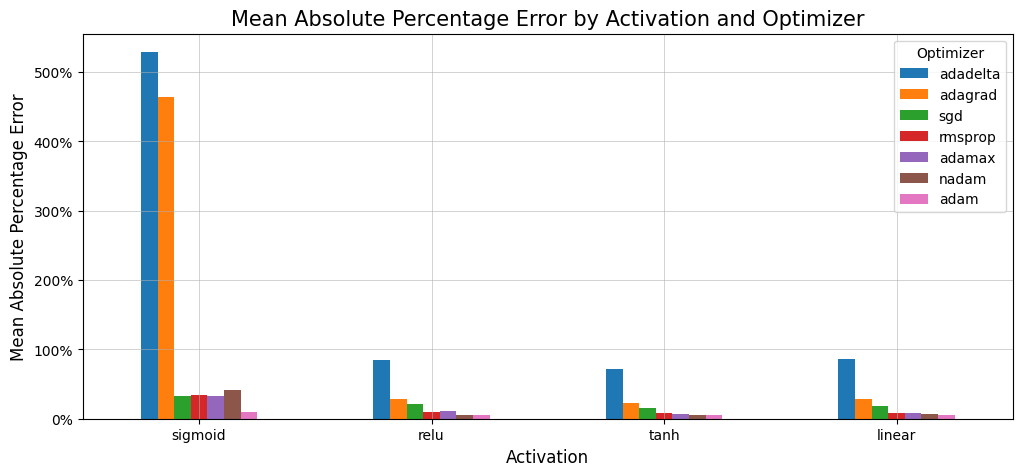

In [104]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

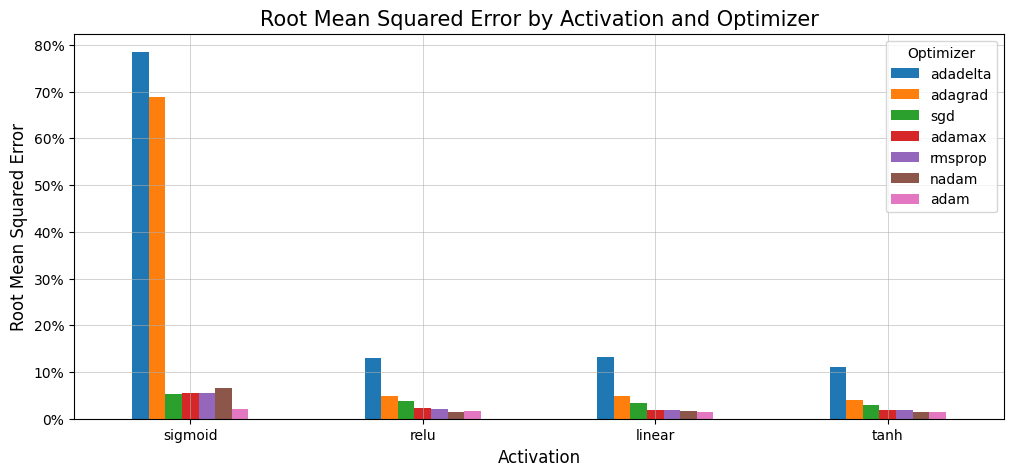

In [105]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

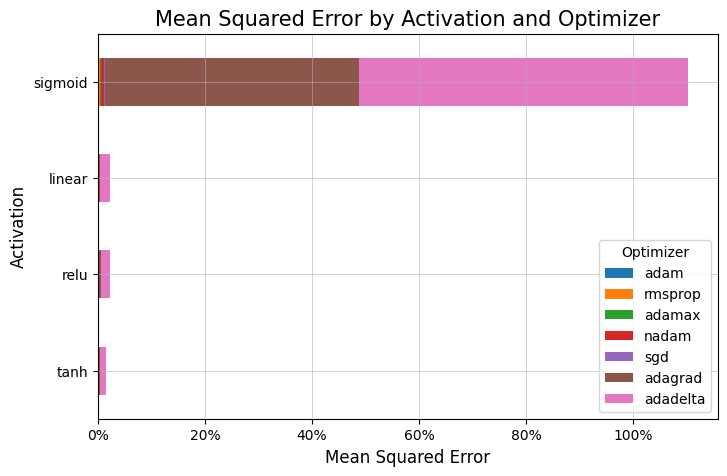

In [106]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='barh', stacked=True, ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

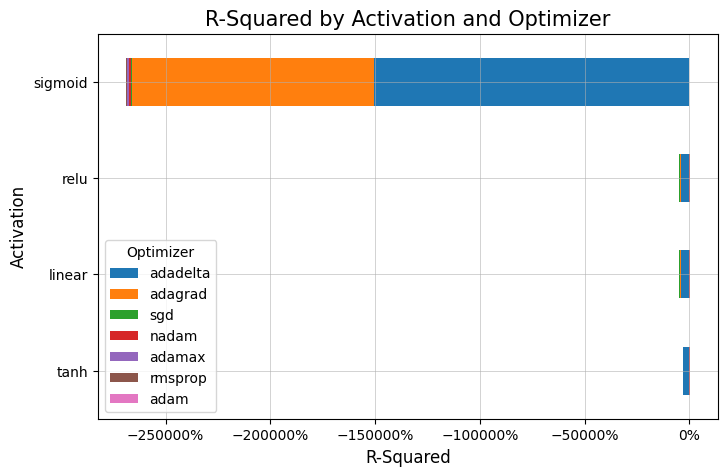

In [107]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', stacked=True, ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()